# Read SUMMA output

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Offline Turbulence Package
import turbpy

# Customize
sns.set_style("whitegrid")
sns.set_context('paper')
%matplotlib inline

In [2]:
# Stats libraries
import statsmodels.api as sm
import scipy.stats as stats


In [3]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/'

dirProj = dirPre + 'SnowHydrology/proj/ModTsfc/'
dirPrint = dirProj + 'Graphics'
dirData = dirProj + 'data'

## Functions to quickly evaluate all model output

In [4]:
def sortFun(s):
    if 'high' in s and 'L' in s:
        return(4)
    elif 'high' in s and 'S' in s:
        return(3)
    elif 'low' in s and 'S' in s:
        return(2)
    elif 'low' in s and 'L' in s:
        return(1)

In [5]:
def snowPresence(ds, obs):
    snowPresenceArray = (obs.SP == 1) & (ds['scalarSWE'] > 0) & (ds['scalarSurfaceTemp'] < 273.2)
    return(snowPresenceArray)

def createSnowSurfTemp(ds):
    snowTempArray = ds['scalarSurfaceTemp'].where((ds['scalarSWE'] > 0) & (ds['scalarSurfaceTemp'] < 273.2))
    return(snowTempArray)

## Forcing data

In [6]:
# ----------
# Sites and forcing data
siteNames = ['SWA', 'CDP']
siteYears = {'SWA': np.arange(2006, 2012),
             'CDP': np.arange(2002, 2010)}

d1 = {'CDP': datetime(2002, 10, 1), 'SWA': datetime(2006, 10, 1)}
d2 = {'CDP': datetime(2010, 9, 30, 22, 0, 0), 'SWA': datetime(2012, 9, 30, 23, 0, 0)}

os.chdir(dirData)
CDPforce = xr.open_dataset('CDP.ModTsfc.nc')
CDPforce = CDPforce.loc[dict(time = slice(d1['CDP'], d2['CDP']))]
CDPforce_daily = CDPforce.resample(how='mean', freq='d', dim='time')

SWAforce = xr.open_dataset('SWA.ModTsfc.nc')
SWAforce = SWAforce.loc[dict(time = slice(d1['SWA'], d2['SWA']))]
SWAforce_daily = SWAforce.resample(how='mean', freq='d', dim='time')

# ----------
# Summa modeling results for each site
os.chdir(dirData  + '/summaResults')

SWA = xr.open_dataset('SWA.summaResults.forcing.nc')
SWA = xr.concat([SWA, xr.open_dataset('SWA.summaResults.internal.nc')], 'expID')
print(SWA)

CDP = xr.open_dataset('CDP.summaResults.forcing.nc')
CDP = xr.concat([CDP, xr.open_dataset('CDP.summaResults.internal.nc')], 'expID')
print(CDP)

<xarray.Dataset>
Dimensions:                (expID: 45, time: 52608)
Coordinates:
  * time                   (time) datetime64[ns] 2006-10-01 ...
    exp                    (expID) object 'longwaveBias' 'longwaveBias' ...
    family                 (expID) object 'lowLW' 'lowLW' 'highLW' 'highLW' ...
  * expID                  (expID) object 'lowLW_L' 'lowLW_S' 'highLW_S' ...
Data variables:
    scalarRainPlusMelt     (expID, time) float64 -9.999e+03 -9.999e+03 ...
    scalarSWE              (expID, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    scalarSnowSublimation  (expID, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    scalarInfiltration     (expID, time) float64 1.784e-07 3.584e-09 0.0 0.0 ...
    scalarSurfaceRunoff    (expID, time) float64 3.338e-12 7.387e-14 0.0 0.0 ...
    scalarSurfaceTemp      (expID, time) float64 283.1 280.9 279.7 278.8 ...
    scalarSenHeatTotal     (expID, time) float64 -75.53 -20.79 -19.85 -15.34 ...
    scalarLatHeatTotal     (expID, time) float64

## Model output

In [7]:
# ----------
# Experiment names - Structure Uncertainty
experiments = ['longwaveBias', 'shortwaveBias', 'specHumidBias',
               'airTempBias', 'windBias', 'layers',
               'thermalCond', 'stability']
expMetUnc = ['longwaveBias', 'shortwaveBias', 'specHumidBias',
               'airTempBias', 'windBias']
expIntern = ['layers', 'thermalCond', 'stability']
experimentType = {'forcing': expMetUnc, 'internal': expIntern}
force = {'SWA': SWAforce, 'CDP': CDPforce}
force_daily = {'SWA': SWAforce_daily, 'CDP': CDPforce_daily}
results = {'SWA': SWA, 'CDP': CDP}

# Met uncertainty experiment IDs and values
expNames = {'longwaveBias': ['lowLW_L','lowLW_S', 'highLW_S', 'highLW_L']}
expBias = {'longwaveBias': {'lowLW_L': -25, 'lowLW_S': -10, 'highLW_S': 10, 'highLW_L': 25}}

expNames['shortwaveBias'] = ['lowSW_L','lowSW_S', 'highSW_S', 'highSW_L']
expBias['shortwaveBias'] = {'lowSW_L': -80, 'lowSW_S': -30, 'highSW_S': 30, 'highSW_L': 80}

expNames['specHumidBias'] = ['lowQS_L','lowQS_S', 'highQS_S', 'highQS_L']
expBias['specHumidBias'] = {'lowQS_L': -25,  'lowQS_S': -10, 'highQS_S': 10, 'highQS_L': 25}

expNames['airTempBias'] = ['lowTair_L','lowTair_S', 'highTair_S', 'highTair_L']
expBias['airTempBias'] = {'lowTair_L': -3, 'lowTair_S': -1.5, 'highTair_S': 1.5, 'highTair_L': 3}

expNames['windBias'] = ['lowU_L','lowU_S', 'highU_S', 'highU_L']
expBias['windBias'] = {'lowU_L': -3, 'lowU_S': -1.5, 'highU_S': 1.5, 'highU_L': 3}

metName = {'longwaveBias': 'LWRadAtm',
           'shortwaveBias': 'SWRadAtm',
           'specHumidBias': 'spechum',
           'airTempBias': 'airtemp',
           'windBias': 'windspd'}

metNameTitle = {'longwaveBias': 'Longwave Bias (Wm$^{-2}$)',
           'shortwaveBias': 'Shortwave Bias (Wm$^{-2}$)',
           'specHumidBias': 'Relative Humiditiy Bias',
           'airTempBias': 'Air Temperature Bias ($^{\circ}$C)',
           'windBias': 'Wind Speed Bias (m s$^{-1}$)'}

# Layer
expNames['layers'] = ['layerThin', 'layerThick', 'jrdn1991', 'CLM_2010']

# Thermal conductivity
arrayNames = ['tyen1965', 'melr1977', 'jrdn1991', 'smnv2000']
arrayAppend = ['Mid', 'Low', 'High']
expNames['thermalCond'] = [name + '_' + append for name in arrayNames for append in arrayAppend]

# Stability
arrayAppend = ['Low', 'Mid', 'High']
arrayNames = ['standard', 'louisinv', 'mahrtexp']
expNames['stability'] = [name + '_' + append for name in arrayNames for append in arrayAppend]

internalNames = {'stability': ['standard', 'louisinv', 'mahrtexp'],
                 'layers': ['layerThin', 'layerThick', 'jrdn1991', 'CLM_2010'],
                 'thermalCond': ['tyen1965', 'melr1977', 'jrdn1991', 'smnv2000']}

# ----------
# Scalar variables to extract from output
scalar_data_vars = ['scalarRainPlusMelt', 'scalarSWE', 'scalarSnowSublimation', 
                    'scalarInfiltration', 'scalarSurfaceRunoff', 'scalarSurfaceTemp',
                    'scalarSenHeatTotal', 'scalarLatHeatTotal', 'scalarSnowDepth']

In [8]:
# snow surface temperature and snow presence
SWA['SP'] = snowPresence(SWA, SWAforce)
SWA['scalarSnowTemp'] = createSnowSurfTemp(SWA)
CDP['SP'] = snowPresence(CDP, CDPforce)
CDP['scalarSnowTemp'] = createSnowSurfTemp(CDP)

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in less
  if not reflexive


In [10]:
for s in siteNames:
    tempDat = {}
    for s in siteNames:
        for expN in expMetUnc:
            if expN == 'precipBias':
                continue
            os.chdir('/Users/karllapo/gdrive/SnowHydrology/proj/ModTsfc/summa/ModTsfc_summa/input/'
                     + expN + '/' + s + '/')

            # Experiment specific files
            for n, expID in enumerate(expNames[expN]):
                tempDatName = s + '.ModTsfc.ModelForcing.' + expID + '.nc'
                fieldForBias = metName[expN]
                tempDat[expID] = xr.open_dataset(tempDatName)

        resultsDataSet = xr.concat([tempDat[scen] for exp in expMetUnc for scen in expNames[exp]], dim='expID')
        resultsDataSet.coords['expID'] = list([n for exp in expMetUnc for n in expNames[exp]])
        # Recreate time series since summa's time format does not play well with datetime
        resultsDataSet['time'] = pd.date_range(d1[s], d2[s], freq='H')

        # Add to the results DataSet
        resultsDataSet = resultsDataSet.reindex_like(results[s]).squeeze()
        for expN in expMetUnc:
            fieldForBias = metName[expN]
            results[s][fieldForBias] = (('expID', 'time'), resultsDataSet[fieldForBias])

In [29]:
# -----------
# Format model output
# for s in siteNames:
s = 'SWA'
ds = results[s]
    
# Bias
ds['bias'] = ds.scalarSnowTemp - 273.15 - force[s].snowTs

# Bias in min daily
dsMin = ds.scalarSnowTemp.resample(how='min', dim='time', freq='d')\
         - 273.15\
         - force[s].snowTs.resample(how='min', dim='time', freq='d')

# Diurnal range
dsMax = ds.scalarSnowTemp.resample(how='max', dim='time', freq='d')\
        - 273.15\
        - force[s].snowTs.resample(how='max', dim='time', freq='d')

# Diurnal range
dsAmp = (ds.scalarSurfaceTemp.resample(how='max', dim='time', freq='d')
         - ds.scalarSurfaceTemp.resample(how='min', dim='time', freq='d'))
# Diurnal amplitude of observed Ts
diurnalTs = (force[s].snowTs.resample(how='max', dim='time', freq='d')
             - force[s].snowTs.resample(how='min', dim='time', freq='d'))

# Assign to DataSet
ds = ds.resample(how='mean', dim='time', freq='d')
ds['biasAmp'] = dsAmp - diurnalTs
ds['diurnalTs'] = dsAmp
ds['biasMin'] = dsMin
ds['biasMax'] = dsMax

# Only have some variables
varsForPairPlot = ['LWRadAtm', 'SWRadAtm', 'spechum', 'airtemp', 'windspd',
               'bias', 'biasAmp', 'biasMin', 'biasMax']
ds = ds[varsForPairPlot]

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in less
  if not reflexive


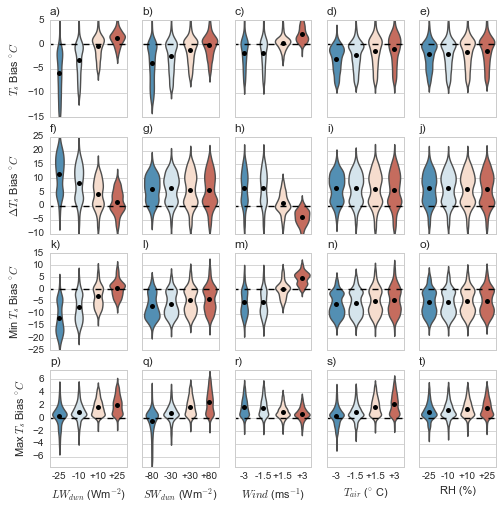

In [31]:
import string
alphabet = list(string.ascii_lowercase)

sns.set_context("paper", font_scale=1.25)
def removeOutliers(dsin, field):
    for e in dsin.expID:
        temp = dsin.loc[dict(expID=e)][field]
        sigma = temp.std(dim='time')
        mu = temp.mean(dim='time')
        temp[temp > mu + 2 * sigma] = np.nan
        temp[temp < mu - 2 * sigma] = np.nan
        dsin.loc[dict(expID=e)][field] = temp
    return(dsin)

# Axis labels
# X Axis
xVars = ['longwaveBias', 'shortwaveBias', 'windBias', 'airTempBias', 'specHumidBias']
xTitles = {'longwaveBias': '$LW_{dwn}$ (Wm$^{-2}$)', 'shortwaveBias': '$SW_{dwn}$ (Wm$^{-2}$)',
         'windBias': '$Wind$ (ms$^{-1}$)', 'airTempBias': '$T_{air}$ ($^{\circ}$ C)',
         'specHumidBias': 'RH (%)'}
xTicks = {'longwaveBias': [str(-25), str(-10), '+' + str(10), '+' + str(25)],
          'shortwaveBias': [str(-80), str(-30), '+' + str(30), '+' + str(80)],
          'windBias': [str(-3), str(-1.5), '+' + str(1.5), '+' + str(3)],
          'airTempBias': [str(-3), str(-1.5), '+' + str(1.5), '+' + str(3)],
          'specHumidBias': [str(-25), str(-10), '+' + str(10), '+' + str(25)]}

# Y Axis
yVars = ['bias', 'biasAmp', 'biasMin', 'biasMax']
if s == 'SWA':
    yLims = {'bias': [-15, 5], 'biasAmp': [-10, 25], 'biasMin': [-25, 15], 'biasMax': [-7.5, 7.5]}
if s == 'CDP':
    yLims = {'bias': [-10, 10], 'biasAmp': [-15, 15], 'biasMin': [-15, 15], 'biasMax': [-7.5, 7.5]}
yTitles = {'bias': '$T_s$ Bias $^{\circ}C$', 'biasAmp': '$\Delta T_s$ Bias $^{\circ}C$',
           'biasMin': 'Min $T_s$ Bias $^{\circ}C$', 'biasMax': 'Max $T_s$ Bias $^{\circ}C$'}

fig, axes = plt.subplots(4, 5, figsize=(8, 8), sharey='row', sharex='col')
for nx, x in enumerate(xVars):
    for ny, y in enumerate(yVars):
        ax = axes[ny, nx]

        # Select appropriate experiments, remove outliers, convert to pandas
        tempds = ds.swap_dims({'expID':'exp'}).sel(exp=x)
        tempds = removeOutliers(tempds.swap_dims({'exp': 'expID'}), y)
        tempdf = tempds.to_dataframe().reset_index()
        
        # Violin plots
        ax.plot([-10, 10], [0, 0], 'k--')
        sns.violinplot(x='expID', y=y, data=tempdf, ax=ax, palette=sns.color_palette('RdBu_r', 4), inner=None)
        # Mean value for each violin plot
        ax.plot(np.arange(0, 4), tempds.mean(dim='time')[y].values, 'o',
                color='0', markeredgecolor='0.75', markersize=5)
        
        # Formatting
        ax.set_ylim(yLims[y])
        ax.set_xlabel('')
        ax.set_ylabel('')
        if nx == 0:
            ax.set_ylabel(yTitles[y])
        if ny == 3:
            ax.set_xlabel(xTitles[x])
            ax.set_xticklabels(xTicks[x])
        ax.set_title(alphabet[5 * ny + nx] + ')', loc='left')
# fig.tight_layout()
os.chdir(dirPrint)
fig.savefig(s + '.allBias_TsImpact.violinPlots.pdf')
fig.savefig(s + '.allBias_TsImpact.violinPlots.png')